In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import os
import polars as pl

# 市场规律统计

In [36]:
def structure_stats(fret, *states):
    state_frets = []
    counts = []; wgts = []; winrates = []; odds = []; kelly = []; avgrets = []; avgstds = []; avgsps = []
    for state in states:
        state_frets.append(eval("fret[state]"))
    for sf in state_frets:
        counts.append(len(sf))
        wgts.append('{:.2%}'.format(len(sf)/len(fret)))
        avgrets.append('{:.4%}'.format(sf.mean()))
        if sf.mean()>0:
            odd = -sf[sf>0].mean()/sf[sf<0].mean()
            winr = (sf>0).mean()
        else:
            odd = -sf[sf<0].mean()/sf[sf>0].mean()
            winr = (sf<0).mean()
        winrates.append('{:.2%}'.format(winr))
        odds.append('{:.4f}'.format(odd))
        kelly.append('{:.4f}'.format(winr*odd-(1-winr)))
        avgstds.append('{:.2%}'.format(sf.std()))
        avgsps.append('{:.2f}'.format(np.abs(sf.mean()/sf.std())))
    print(pd.DataFrame({'count': counts, 'wgt': wgts, 'avgret': avgrets, 'avgstd': avgstds, 'winr': winrates, 'odd': odds, 'kelly': kelly, 'avg sp': avgsps}, index=np.arange(1, len(states)+1)))

def annual_stat(fret, state):
    df = pd.DataFrame({'fret': fret[state]})
    ann_num = pd.DataFrame({'fret': fret, 'year': fret.index.str[:4]}).groupby('year')['fret'].count()
    df['year'] = df.index.str[:4]
    group = df.groupby('year')['fret']
    count = group.count()
    wgt = count / ann_num
    avgret = group.mean()
    avgstd = group.std()
    if df['fret'].mean()>0:
        winr = group.apply(lambda x: (x>0).mean())
        odd = group.apply(lambda x: -x[x>0].mean()/x[x<0].mean())
    else:
        winr = group.apply(lambda x: (x<0).mean())
        odd = group.apply(lambda x: -x[x<0].mean()/x[x>0].mean())
    kelly = winr*odd - (1-winr)
    avgsp = avgret/avgstd
    wgt = wgt.map(lambda x: '{:.2%}'.format(x))
    avgret = avgret.map(lambda x: '{:.4%}'.format(x))
    avgstd = avgstd.map(lambda x: '{:.2%}'.format(x))
    winr = winr.map(lambda x: '{:.2%}'.format(x))
    odd = odd.map(lambda x: '{:.4f}'.format(x))
    kelly = kelly.map(lambda x: '{:.2f}'.format(x))
    avgsp = avgsp.map(lambda x: '{:.2f}'.format(x))
    print(pd.DataFrame({'count': count, 'wgt': wgt, 'avgret': avgret, 'avgstd': avgstd, 'winr': winr, 'odd': odd, 'kelly': kelly, 'avg sp': avgsp}))

In [ ]:
df = pd.read_pickle('./data/hsi.pkl')
df = df.loc[(df.index<='20230531')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
vs = df['volume'].rolling(5).std()
f1 = vs.rolling(5).rank()
state1 = f1==4
structure_stats(fret, *(state1,))
# annual_stat(fret, state3)
# annual_stat(fret, state4)

In [299]:
df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<='20230630')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
mid = 0.5*(df['high']+df['low'])
f1 = df['open']-mid
f2 = df['close']-mid
f3 = df['volume'].diff(1)
atr = pd.concat([df['high']-df['low'], (df['high']-df['close'].shift(1)).abs(), (df['low']-df['close'].shift(1)).abs()], axis=1).max(1)
f4 = (df['volume']/atr).rolling(5).mean().rolling(5).rank(pct=True)
f5 = df['volume'].rolling(5).rank(pct=True)
f6 = df['low'].rolling(5).rank(pct=True)
state1 = (f1<0)&(f2<0)
state2 = (f1>0)&(f2>0)
state3 = (f1<0)&(f2>0)&(f3>0)&(f4<0.5)
state4 = (f1<0)&(f2>0)&(f3<0)&(f4>0.5)
state5 = (f1>0)&(f2<0)&(f5<0.5)&(f6<0.5)
state6 = (f1>0)&(f2<0)
structure_stats(fret, *(state1, state2, state3, state4, state5, state6))
# annual_stat(fret, state6)

   count     wgt    avgret avgstd    winr     odd   kelly avg sp
1    143  10.73%   0.4572%  1.75%  63.64%  1.1385  0.3609   0.26
2    231  17.33%  -0.2839%  1.56%  55.84%  1.3324  0.3025   0.18
3    131   9.83%   0.2783%  1.26%  58.78%  1.2478  0.3212   0.22
4    153  11.48%  -0.1680%  1.47%  54.25%  1.1411  0.1615   0.11
5    119   8.93%   0.0685%  1.63%  57.14%  0.8398  0.0513   0.04
6    414  31.06%   0.0055%  1.67%  54.59%  0.8393  0.0040   0.00


In [ ]:
df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<='20230531')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
f1 = (df['high']+df['low'])/(df['open']+df['close'])-1
f2 = f1.rolling(6).apply(lambda x: -x[x>0].mean()/x[x<0].mean())
f3 = f1.rolling(2).mean()
f4 = df['low'].rolling(5).skew()
f5 = 2*df['close']-df['high']-df['low']
f6 = 2*df['open']-df['high']-df['low']
state1 = (f1>0)&(f2>=1)
state2 = (f3>0)&(f4>0)
state3 = (f3<0)&(f4<0)
state4 = (f3>0)&(f5<0)
state5 = (f3<0)&(f5>0)
state6 = (f4>0)
state7 = (f4<0)
structure_stats(fret, *(state1, state2, state3, state4, state5, state6, state7))
# annual_stat(fret, state5)

In [ ]:
pd.read_feather('./dump/etftiming1.feather')
# pd.read_pickle('./pnl/etftiming1.pnl.pkl')

,pnl,dpos
date,,
2018-01-02,0.000000,0.000000
2018-01-03,0.000000,0.000000
2018-01-04,0.000000,0.000000
2018-01-05,0.000000,0.000000
2018-01-08,0.000000,0.000000
...,...,...
2025-06-24,0.003436,0.906461
2025-06-25,0.001900,0.799019
2025-06-26,-0.001852,0.855428


# 不同策略对比

## 1.1 因子/策略相关性测试

In [206]:
check_id = 'timing1_v1'
compare = []
pnl0 = pd.read_pickle(f'./pnl/{check_id}.pnl.pkl')['pnl']
pnl0.name = check_id
compare.append(pnl0)
for pnl_id in os.listdir('./pnl'):
    if pnl_id.startswith('timing') and pnl_id[:-8] != check_id:
            pnl = pd.read_pickle(f'./pnl/{pnl_id}')['pnl']
            pnl.name = pnl_id[:-8]
            # print(f'{pnl_id[:-8]}: {pnl.corr(basic):.4)
            compare.append(pnl)
compare = pd.concat(compare, axis=1, join='inner')
compare = compare[compare.index<='20230630']
print(compare.drop(columns=[check_id]).corrwith(compare[check_id]))

timing1    0.887654
timing2    0.313359
timing4    0.361197
timing5    0.738063
timing6    0.751117
dtype: float64


## 1.2 策略曲线对比

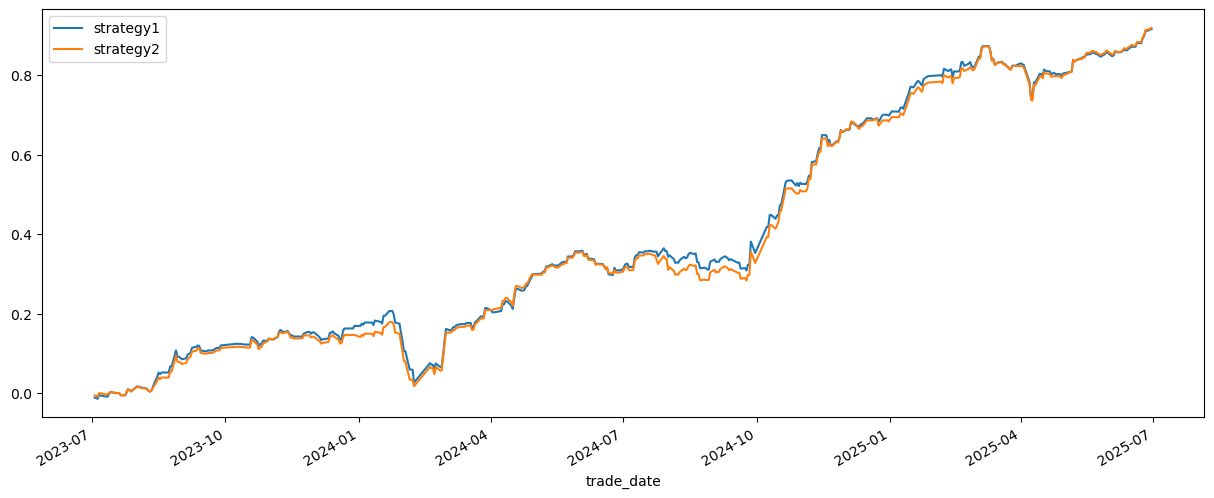

In [211]:
nav1 = pd.read_pickle('./pnl/timing5.pnl.pkl')
nav1 = nav1.loc[nav1.index>='20230701', 'pnl'].cumsum()
nav1.index = pd.to_datetime(nav1.index)
nav2 = pd.read_pickle('./pnl/timing6.pnl.pkl')
nav2 = nav2.loc[nav2.index>='20230701', 'pnl'].cumsum()
nav2.index = pd.to_datetime(nav2.index)
ax = nav1.plot(label='strategy1', figsize=(15,6))
ax.plot(nav2, label='strategy2')
ax.legend()

In [193]:
pd.read_pickle('./pnl/timing1.pnl.pkl')
# pd.read_pickle('./dump/timing5.pkl')

,pnl,dpos
trade_date,,
20180102,NaN,NaN
20180103,0.000000,0.0
20180104,0.008132,1.0
20180105,0.003122,0.0
20180108,-0.000330,2.0
...,...,...
20250624,0.000000,0.0
20250625,0.018462,1.0
20250626,0.012312,0.0


## 1.3 策略绩效回顾

In [215]:
def stats(pnl_pd: pd.DataFrame):
    pnl_pd.index = pd.to_datetime(pnl_pd.index)
    dateindex = pnl_pd.index
    pnl_pd['nav'] = pnl_pd['pnl'].cumsum()
    pnl_pd['year'] = pnl_pd.index.year.values
    # total
    ret = pnl_pd['pnl'].mean() * 250
    sp = pnl_pd['pnl'].mean() / pnl_pd['pnl'].std() * np.sqrt(250)
    pnl_pd['dd_T'] = pnl_pd['nav'].cummax() - pnl_pd['nav']
    mdd = pnl_pd['dd_T'].max()
    dd_end = pnl_pd['dd_T'].idxmax()
    dd_start = pnl_pd.loc[:dd_end, 'nav'].idxmax()
    winr = (pnl_pd['pnl']>0).mean()
    odd = -pnl_pd.loc[pnl_pd['pnl']>0, 'pnl'].mean() / pnl_pd.loc[pnl_pd['pnl']<0, 'pnl'].mean() 
    calmar = ret / mdd
    tvr = pnl_pd['dpos'].mean()*250

    # yearly
    gpnl = pnl_pd.groupby('year')
    pnl_pd['dd_y'] = gpnl['nav'].cummax() - pnl_pd['nav']
    ret_y = gpnl['pnl'].mean() * 250
    sp_y = gpnl['pnl'].mean() / gpnl['pnl'].std() * np.sqrt(250)
    mdd_y = gpnl['dd_y'].max()
    dd_end_y = gpnl['dd_y'].idxmax()
    dd_start_y = gpnl.apply(lambda x: x.loc[:dd_end_y[x['year'].values[0]], 'nav'].idxmax())
    winr_y = gpnl['pnl'].apply(lambda x: (x>0).mean())
    odd_y = -gpnl['pnl'].apply(lambda x: x[x>0].mean() / x[x<0].mean())
    calmar_y = ret_y / mdd_y
    tvr_y = gpnl['dpos'].mean() * 250

    index1 = gpnl.head(1).index
    index2 = gpnl.tail(1).index
    out = pd.DataFrame({'ret': ret_y.values*100,
                        'sp': sp_y.values,
                        'dd': mdd_y.values*100,
                        'dd_start': dd_start_y.values,
                        'dd_end': dd_end_y.values,
                        'anntvr': tvr_y.values,
                        'winr': winr_y.values*100,
                        'odd': odd_y.values,
                        'calmar': calmar_y.values}, index=pd.MultiIndex.from_arrays([index1, index2], names=['from', 'to']))
    out.loc[(dateindex[0], dateindex[-1]), :] = [ret*100, sp, mdd*100, dd_start, dd_end, tvr, winr*100, odd, calmar]
    print(out)

In [218]:
pnl = pd.read_pickle('./pnl/etftiming2.pnl.pkl')
stats(pnl)

                             ret        sp        dd   dd_start     dd_end  \
from       to                                                                
2018-01-02 2018-12-28   6.803605  1.547170  7.918114 2018-09-14 2018-11-29   
2019-01-02 2019-12-31   8.445508  2.452432  2.227018 2019-07-03 2019-08-27   
2020-01-02 2020-12-31  11.081166  1.739305  2.989121 2020-06-15 2020-07-27   
2021-01-04 2021-12-31   0.256793  0.058076  3.555082 2021-07-08 2021-11-26   
2022-01-04 2022-12-30   5.121190  0.633341  4.426184 2022-03-15 2022-03-17   
2023-01-03 2023-12-29   4.155392  0.865180  5.628569 2023-01-31 2023-06-06   
2024-01-02 2024-12-31   4.308986  0.566307  7.951426 2024-08-19 2024-10-08   
2025-01-02 2025-06-30  19.791033  2.270771  3.362343 2025-04-09 2025-04-16   
2018-01-02 2025-06-30   6.647777  1.099471  7.951426 2024-08-19 2024-10-08   

                           anntvr       winr       odd    calmar  
from       to                                                     
2018-01

C:\Users\User\AppData\Local\Temp\ipykernel_28760\1405865654.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_start_y = gpnl.apply(lambda x: x.loc[:dd_end_y[x['year'].values[0]], 'nav'].idxmax())


# 交易对胜率提升

In [ ]:
# df = pd.read_pickle('./data/[v2交易对stk]无强制闭环_20241207.pkl')
# df = df[df.factor_date>=pd.to_datetime('20200101')].reset_index(drop=True)

alpha = pd.read_pickle('./dump/alpha5_v1.pkl')
alpha.index = pd.to_datetime(alpha.index)
alpha = alpha.rank(axis=1, method='dense', pct=True)
alpha_ts = alpha.stack().reset_index()
alpha_ts.columns = ['factor_date', 'code', 'alpha']

df1 = df.merge(alpha_ts, on=['code', 'factor_date'], how='left')
# low = (df1.loc[df1['alpha']<0.33, 'return']>0).mean()
low = len(df1.loc[df1['alpha']<0.33, 'return'])/len(df1)
# med = (df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return']>0).mean()
med = len(df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return'])/len(df1)
# high = (df1.loc[df1['alpha']>=0.67, 'return']>0).mean()
high = len(df1.loc[df1['alpha']>=0.67, 'return'])/len(df1)
# print(low, med, high)

df1['year'] = df1['factor_date'].dt.year
gpdf = df1.groupby('year')[['alpha', 'return']]
# glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
glow = gpdf.apply(lambda x: len(x.loc[x['alpha']<0.33, 'return'])/len(x))
# gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
gmed = gpdf.apply(lambda x: len(x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return'])/len(x))
# ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
ghigh = gpdf.apply(lambda x: len(x.loc[x['alpha']>=0.67, 'return'])/len(x))
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

In [ ]:
df = pd.read_feather('./dump/hfetf.feather')
gdf = df.groupby('datetime')
print(f"平均每小时信号量: {gdf['dpos'].apply(lambda x: (x.abs()>0).sum()).mean()}")
print(f"平均单笔收益: {(gdf['pnl'].sum()/gdf['dpos'].apply(lambda x: (x.abs()>0).sum())).mean()}")
print(f"平均胜率: {(df['pnl']>0).mean()}")
print(f"平均盈亏比: {-(df['pnl'][df['pnl']>0]).mean()/(df['pnl'][df['pnl']<0]).mean()}")

In [18]:
df=pd.read_feather('./dump/hfetf.feather')
# M = 5
# bins = np.linspace(-1, 1, 2*M+2)
# labels = np.linspace(-1, 1, 2*M+1)
# df['pos'] = df.groupby('code')['factor'].transform(lambda col: pd.cut(col.rolling(60).rank(pct=True), bins=bins, labels=labels).astype(float))

In [28]:
df = pd.read_excel('../策略/ETF T0/活跃ETF池.xlsx')
df['代码'] = df['代码'].astype(str)
df.loc[df['代码'].str.startswith('5'), '代码'] = df['代码']+'.SH'
df.loc[df['代码'].str.startswith('1'), '代码'] = df['代码']+'.SZ'
df = df[df['市场'].notna()]
df['代码'].to_csv('./derivative_data/activeetf.csv')

In [275]:
from datetime import time
df = pd.read_feather('./dump/hfetf2.feather')
df[df['datetime'].dt.time==time(10,30)]

,code,datetime,factor,pos
0,159605.SZ,2023-07-03 10:30:00,3.0,0.0
1,513650.SH,2023-07-03 10:30:00,-6.0,0.0
2,159834.SZ,2023-07-03 10:30:00,2.0,0.0
3,162415.SZ,2023-07-03 10:30:00,-2.0,0.0
4,161126.SZ,2023-07-03 10:30:00,-3.0,0.0
...,...,...,...,...
239593,160723.SZ,2025-06-30 10:30:00,3.0,0.0
239594,159577.SZ,2025-06-30 10:30:00,-8.0,0.0
239595,159981.SZ,2025-06-30 10:30:00,-0.0,0.0
239596,513400.SH,2025-06-30 10:30:00,-7.0,0.0
